
---

# DL HW2
 - Pretrained Models

In this assignment, you will analyze and compare a few pre-trained models from the field of computer vision.

The assignment is divided into several tasks:

- **EX1 - The Imagenette Dataset (10 pts)**  
- **EX2 - Pretrained Models (20 pts)**  
- **EX3 - Visualizing Feature Maps (30 pts)**  
- **EX4 - K-Nearest Neighbors (KNN) in the Embedding Space (50 pts)**  

Note: In this assignment, you will not train any models or aim to reach specific accuracy levels. Instead, you will investigate the behavior of a few pre-trained models.

---

## Grading

The grading for each section is indicated in the title. Grading will be based on the following criteria:

- **Following Instructions**  
- **Presentation**: Clear figures (with labels, titles, etc.), well-written discussions and comments, organized notebook, no leftover debugging prints, and no redundant functions.  
- **Clear and Efficient Code**: Your code should be clear and neat. Write clear comments and avoid `for loops` when vectorized operations are available. Use the GPU when possible.  
- **Discussion**: Ensure you write a discussion whenever it is required.  

---

Submit the fully executed notebook.

---


# EX1 - Imagenette (Small subset of ImageNet) Dataset (10pts)



1.   Download the ```Imagenette``` dataset from ```torchvision``` ([link](https://pytorch.org/vision/0.19/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette)). Make sure the set size="160px" to avoid long downloading time.
2. Preprocess the data - resize to 256x256 and take a central crop of size 224. ToTensor, Normalize and so on.
3. Describe the dataset: number of samples for each set, classes labels, classes labels distribtuion (are they balanced?)

4. Plot 5 random samples from each class a present them in a ```num_classes X 5``` (rows X columns) grid.






In [17]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import Imagenette
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import random
from tqdm import tqdm


In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]     
    )
])

train_set = Imagenette(
    root="./data",
    split="train",
    size="160px",
    transform=transform,
    download=True
)

val_set = Imagenette(
    root="./data",
    split="val",
    size="160px",
    transform=transform,
    download=True
)




100%|██████████| 99.0M/99.0M [00:58<00:00, 1.70MB/s]


Dataset Information
Number of classes: 10
Classes: [('tench', 'Tinca tinca'), ('English springer', 'English springer spaniel'), ('cassette player',), ('chain saw', 'chainsaw'), ('church', 'church building'), ('French horn', 'horn'), ('garbage truck', 'dustcart'), ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'), ('golf ball',), ('parachute', 'chute')]
Training samples: 9469
Validation samples: 3925


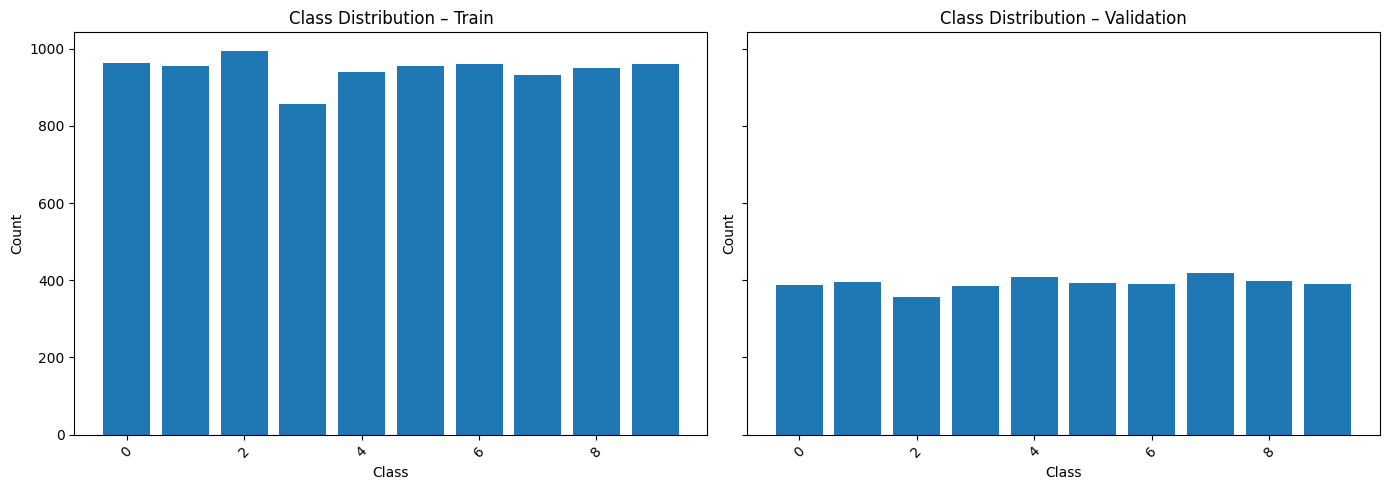

100%|██████████| 10/10 [00:00<00:00, 42.37it/s]


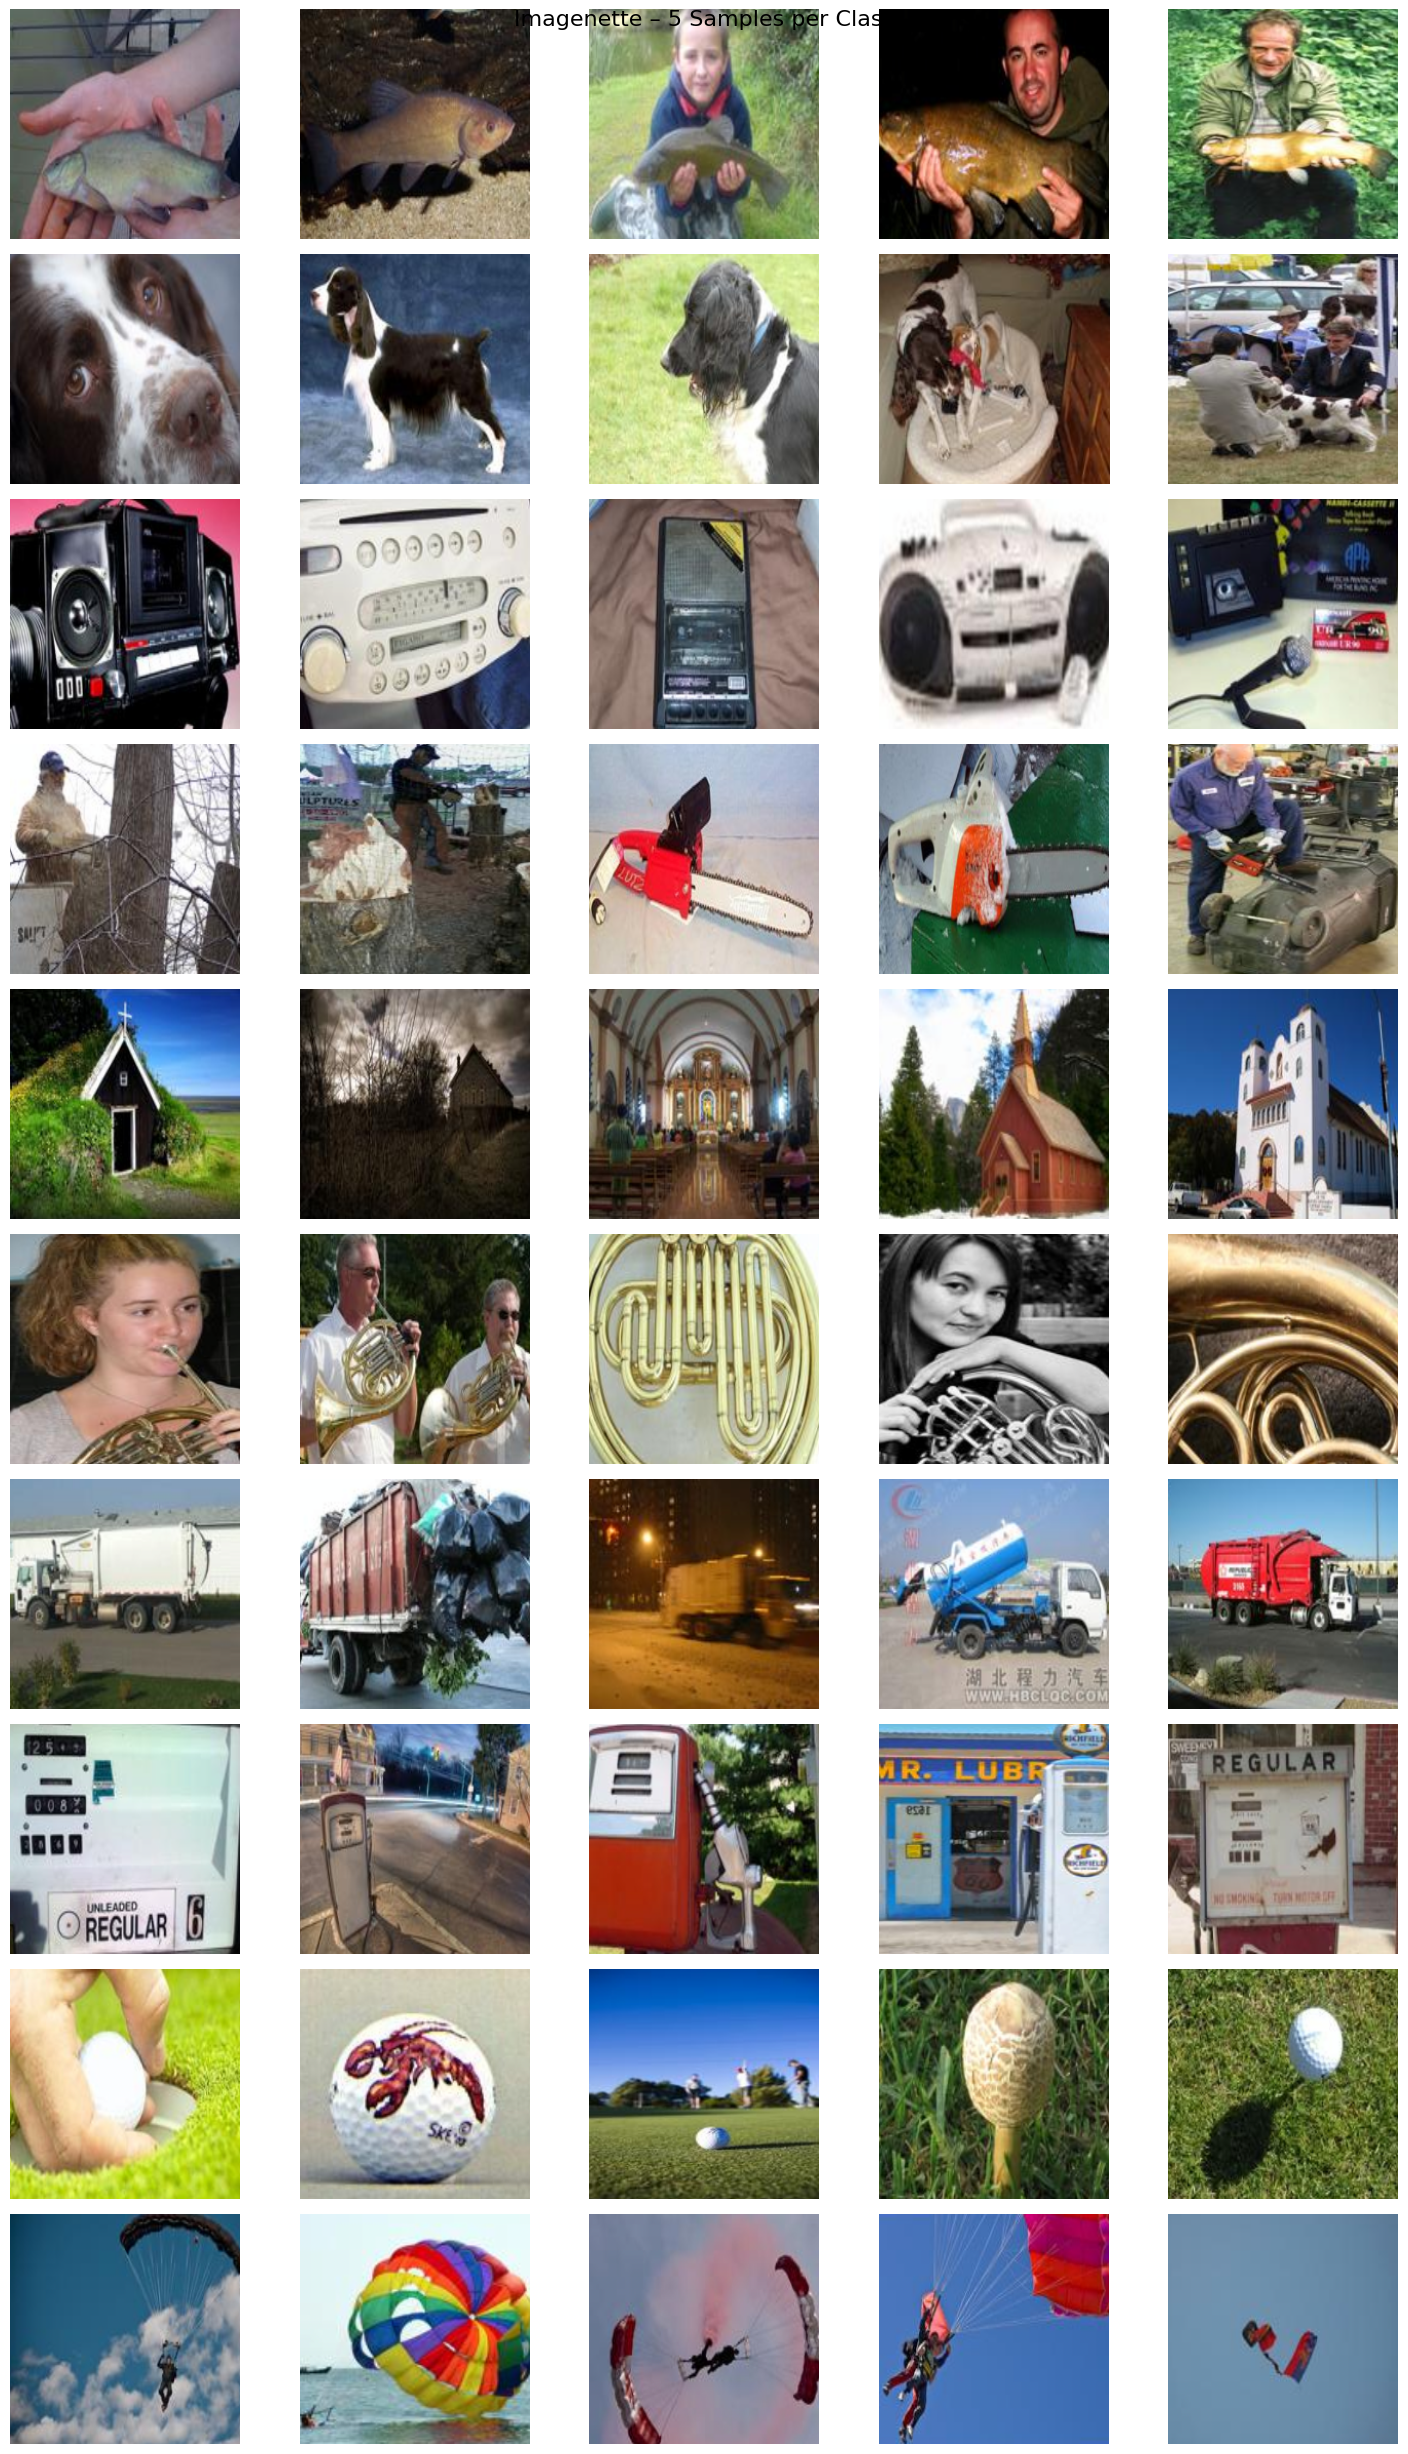

In [23]:
num_train = len(train_set)
num_val = len(val_set)
class_names = train_set.classes
num_classes = len(class_names)

print("Dataset Information")
print(f"Number of classes: {num_classes}")
print(f"Classes: {class_names}")
print(f"Training samples: {num_train}")
print(f"Validation samples: {num_val}")

train_labels = [label for _, label in train_set]
val_labels = [label for _, label in val_set]

train_dist = Counter(train_labels)
val_dist = Counter(val_labels)

# print("\n Training class distribution:")
# for idx, name in enumerate(class_names):
#     print(f"{name[0]:20s}: {train_dist[idx]}")

# print("\n Validation class distribution:")
# for idx, name in enumerate(class_names):
#     print(f"{name[0]:20s}: {val_dist[idx]}")

def plot_hist(ax, counter, set_name):
    labels = list(counter.keys())
    counts = list(counter.values())

    ax.bar(labels, counts)
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")
    ax.set_title(f"Class Distribution – {set_name}")
    ax.tick_params(axis="x", rotation=45)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

plot_hist(axes[0], train_dist, "Train")
plot_hist(axes[1], val_dist, "Validation")

plt.tight_layout()
plt.show()
#Visualization

def denormalize(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean
    return np.clip(img, 0, 1)

indices_per_class = {i: [] for i in range(num_classes)}
for idx, (_, label) in enumerate(train_set):
    indices_per_class[label].append(idx)

fig, axes = plt.subplots(num_classes, 5, figsize=(15, 2.5 * num_classes))

for class_idx in tqdm(range(num_classes)):
    sampled_indices = random.sample(indices_per_class[class_idx], 5)
    for col, sample_idx in enumerate(sampled_indices):
        img, _ = train_set[sample_idx]
        img = denormalize(img)
        axes[class_idx, col].imshow(img)
        axes[class_idx, col].axis("off")

    axes[class_idx, 0].set_ylabel(
        class_names[class_idx],
        rotation=0,
        labelpad=60,
        fontsize=12,
        va="center"
    )

plt.suptitle("Imagenette – 5 Samples per Class", fontsize=16)
plt.tight_layout()
plt.show()

# EX2 - Pretrained models (20pts)

1. Choose 2 models from ```torchvision.models``` ([link](https://pytorch.org/vision/stable/models.html)) that were pretrained on ImageNet. The third model is one of ResNet18/34/50 (the other models can't other ResNet variation).
2. Use ```torch-summary``` to summarize each model for an input of shape ```1x3x224x224```.
3. Describe each model in 2-4 lines. Think carefully what information might be relevant for this homework assignment (see EX3-EX4). It is recommended to read the paper in which each model was first presented but it is not required. You are, however, required to go over model's description in torchvision documentation (see the information tab for ResNet18 for an example [link](https://pytorch.org/vision/0.19/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18) )
4. Summarize the similarities and difference between the 3 models.

In [43]:
from torchvision.models import list_models, get_model
from torchvision.models import resnet50, ResNet50_Weights
from torchsummary import summary

from torchinfo import summary as info

print(list_models())

alexnet = get_model("alexnet", weights="DEFAULT")
ViT = get_model("vit_b_16", weights="DEFAULT")
resnet = resnet50(ResNet50_Weights.DEFAULT)

print("AlexNet:")
summary(alexnet, input_size=(3, 224, 224))
print("\n\nViT:")
print(info(ViT, input_size=(1, 3, 224, 224)))

print("\n\n ResNet50")
summary(resnet, input_size=(3, 224, 224))


['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'deeplabv3_mobilenet_v3_large', 'deeplabv3_resnet101', 'deeplabv3_resnet50', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'fasterrcnn_mobilenet_v3_large_320_fpn', 'fasterrcnn_mobilenet_v3_large_fpn', 'fasterrcnn_resnet50_fpn', 'fasterrcnn_resnet50_fpn_v2', 'fcn_resnet101', 'fcn_resnet50', 'fcos_resnet50_fpn', 'googlenet', 'inception_v3', 'keypointrcnn_resnet50_fpn', 'lraspp_mobilenet_v3_large', 'maskrcnn_resnet50_fpn', 'maskrcnn_resnet50_fpn_v2', 'maxvit_t', 'mc3_18', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'mvit_v1_b', 'mvit_v2_s', 'quantized_googlenet', 'quantized_inception_v3', 'quantized_mobilenet_v2

c:\Users\PC\anaconda3\envs\midterm\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


AlexNet:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14          

# EX3 - Visualizing feature maps (30pts)
In this section you will visualize the feature maps learned by your chosen models.


*   In a convoultion-based models (i.e., ResNet, ConvNext), use the final conv block. If the image resolution is too small do to maxpooling operations, you may choose a different block.
*   In a vision transformer (ViT), use model output without the cls token (if relevant).

Assignments:


1.   Describe the feature map shape for an input image of shape ```1x3x224x224``` (i.e., ```1x512xHxW``` for some model).
2. Choose 1 class from Imagenette and sample 10 random images.
3. Extract the feature maps from each model and perform PCA on the channel dim and reduce it to 3. The output should be of size ```10x3xHxW```
4. Resize the features to 112x112 and plot the images for each model (3 row x 10 columns)
5. Summarize the similarities and difference between the 3 models according to the PCA for the features you have presented.





# EX4 - K-Nearest Neighbors (KNN) in the Embedding Space (50pts)
Also know ans "few-shot/ Zero-shot learning".
Perform KNN classification using the feature vectors from each of the 3 models between the train and test set of Imagenette.


## Visualizing the embedding layer distribution.
* Write an ```extract_embedding(dataloader, model, model_name)``` function that takes in a dataloader and a model and return the ```N x Num_features``` matrix for that set. Make sure that shuffle is off.
* You may write different condition for different models. I.e., the embedding in a ViT model is the ```CLS``` token.

* Plot the t-SNE of the train set for each of the 3 models. Color label the points according to the class labels (see t-SNE implementation by sklearn).

* Write a 2-3 lines disscussion about the data distribution of each model and their comparison.


## Build a KNN ```class``` with the following methods:


*   ```init()```: takes the num_classes and other useful information.
* ```extract_embedding(X, model)```: Extracts the embedding vector for the entire train set using the model. X_features should be ```Nxnum_ft```. Call the function from the previous section.

*   ```fit(X_train, y_train, model)```: Extracts the embedding vector for the entire train set using the ```extract_embedding()``` method and stores it as ```self.X_train_ft``` and ```self.y_labels``` (the labels from the train set).  


*   ```predict(X_test, model, n_neighbors)```: Extracts the embedding vector for the entire train set using the ```extract_embedding()``` method and performs KNN for a given K. Returns the predicted_labels.
* ```compute_accuracy(y_true, y_pred)```.


## Compare the KNN accuracy
using each of the 3 models for $K\in[1,3,5 ]$ and report the results in a table or a graph. Summarize the results in 2-4 lines.
